# RmiRTp generation
This notebook contains all the code used for the generation of RmiRTp. In schematic representation this is what this notebook does

<img src="../misc/RmiRTp_scheme.png" width="2000">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Preprocessing-Wessels-et-al.,-2019" data-toc-modified-id="Preprocessing-Wessels-et-al.,-2019-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing Wessels et al., 2019</a></span></li><li><span><a href="#Preprocessing-TargetScanFlyV7-MREs" data-toc-modified-id="Preprocessing-TargetScanFlyV7-MREs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing TargetScanFlyV7 MREs</a></span></li><li><span><a href="#Preprocessing-TargetScanFlyV7-Integrated" data-toc-modified-id="Preprocessing-TargetScanFlyV7-Integrated-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing TargetScanFlyV7 Integrated</a></span></li><li><span><a href="#TargetScanFlyV7-MREs---Wessels-et-al.,-2019-Overlap" data-toc-modified-id="TargetScanFlyV7-MREs---Wessels-et-al.,-2019-Overlap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TargetScanFlyV7 MREs - Wessels et al., 2019 Overlap</a></span><ul class="toc-item"><li><span><a href="#General-stats" data-toc-modified-id="General-stats-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>General stats</a></span></li><li><span><a href="#Overlap" data-toc-modified-id="Overlap-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Overlap</a></span></li></ul></li><li><span><a href="#Cut-off-election-by-overlap-analysis" data-toc-modified-id="Cut-off-election-by-overlap-analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cut-off election by overlap analysis</a></span></li><li><span><a href="#TargetScanFlyV7-MRE-transcript:pairs-above-cut-off-extraction-and-TargetScanFlyV7-Integrated-filtering-for-the-generation-of-RmiRTp" data-toc-modified-id="TargetScanFlyV7-MRE-transcript:pairs-above-cut-off-extraction-and-TargetScanFlyV7-Integrated-filtering-for-the-generation-of-RmiRTp-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TargetScanFlyV7 MRE transcript:pairs above cut-off extraction and TargetScanFlyV7 Integrated filtering for the generation of RmiRTp</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import biomartpy as bp #https://pypi.org/project/biomartpy/

## Data loading

In [12]:
# TargetScanFlyV7
targetscanMREs_conserved = pd.read_csv(
    'input_files/TargetscanV7/Conserved_Site_Context_Scores.txt',
    sep = "\t")

targetscanMREs_nonconserved = pd.read_csv(
    'input_files/TargetscanV7/Nonconserved_Site_Context_Scores.txt',
    sep = "\t")

targetscanInt = pd.read_csv(
    'input_files/TargetscanV7/Summary_Counts.all_predictions.txt',
    sep = "\t")

targetscan_3UTRs = pd.read_csv(
    'input_files/TargetscanV7/TSFly_r6.19_3UTRs.gff',
    sep = "\t", header = None)

targetscan_families = pd.read_csv(
    'input_files/TargetscanV7/Targetscan_miRNA_fam.csv',
    sep = ";")


# Wessels et al., 2019
wessels = pd.read_csv(
    'input_files/Wessels/41467_2019_9586_MOESM13_ESM.txt',
    sep = "\t", skiprows = [0,1,2])

## Preprocessing Wessels et al., 2019

In [3]:
# Transcripts and UTR position expansion (originally provided clustered)
wessels_full = pd.DataFrame([(tup.microMUMMIE_var, miR, tup.type_R1,
                              tup.gene_R1, tup.gene_id, tup.Chr, tup.strand,
                              tup.start, tup.end, tr, u_start, u_end,
                              tup.porbability_mean)
                             
                       for tup in wessels.itertuples()
                       for miR in tup.miRNA_R1.split(",")
                       for tr, u_start, u_end in zip(tup.transcriptid_R1.split("|"),
                                                     tup.utr_start_R1.rsplit("|"),
                                                     tup.utr_end_R1.rsplit("|"))])

wessels_full.columns = ['microMUMMIE_var', 'miRNA', 'type',
                        'gene', 'gene_id','Chr', 'strand', 
                        'seed_start', 'seed_end', 'transcript_id', 
                        'UTR_start', 'UTR_end', "probability"]

# Filter by peack calling sensitivity/specifity ratio (microMUMMIE_var)
wessels_var05 = wessels_full[wessels_full["microMUMMIE_var"] == 0.5].copy() # levels = [0.01, 0.1, 0.15, 0.2, 0.25, 0.5]
wessels_var05.drop_duplicates(inplace = True) 

# Filter by the micromummie probability
wessels_processed = wessels_var05[wessels_var05["probability"]>=0].copy() # (0-1) not used

# Generation of Transcript:miRNA pair column for the overlap calculation
wessels_processed.loc[:,"Tr:miR"] = wessels_processed["transcript_id"]+":"+ wessels_processed["miRNA"]

# Export
wessels_processed.to_csv("output_files/wessels_processed.tsv", sep = "\t")

wessels_processed

,microMUMMIE_var,miRNA,type,gene,gene_id,Chr,strand,seed_start,seed_end,transcript_id,UTR_start,UTR_end,probability,Tr:miR
66266,0.5,dme-miR-184-3p,6mer3-8,Trp1,FBgn0011584,2L,+,10011984,10011989,FBtr0343741,10011911,10012118,0.719427,FBtr0343741:dme-miR-184-3p
66267,0.5,dme-miR-184-3p,6mer3-8,Trp1,FBgn0011584,2L,+,10011984,10011989,FBtr0305986,10011911,10012118,0.719427,FBtr0305986:dme-miR-184-3p
66268,0.5,dme-miR-276a-3p,6mer2-7,Trp1,FBgn0011584,2L,+,10012081,10012086,FBtr0343741,10011911,10012118,0.940179,FBtr0343741:dme-miR-276a-3p
66269,0.5,dme-miR-276a-3p,6mer2-7,Trp1,FBgn0011584,2L,+,10012081,10012086,FBtr0305986,10011911,10012118,0.940179,FBtr0305986:dme-miR-276a-3p
66270,0.5,dme-bantam-3p,6mer3-8,Trp1,FBgn0011584,2L,+,10013099,10013104,FBtr0079932,10012492,10013170,0.800455,FBtr0079932:dme-bantam-3p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70235,0.5,dme-miR-965-3p,6mer2-7,CG42797,FBgn0261931,X,+,9621751,9621756,FBtr0303709,9621666,9622166,0.956232,FBtr0303709:dme-miR-965-3p
70236,0.5,dme-miR-965-3p,6mer2-7,CG42797,FBgn0261931,X,+,9621751,9621756,FBtr0303708,9621666,9622441,0.956232,FBtr0303708:dme-miR-965-3p
70237,0.5,dme-miR-965-3p,6mer2-7,CG42797,FBgn0261931,X,+,9621751,9621756,FBtr0332963,9621666,9622441,0.956232,FBtr0332963:dme-miR-965-3p
70238,0.5,dme-miR-308-3p,7mer-m1,nej,FBgn0261617,X,-,9666507,9666513,FBtr0333521,9665671,9669706,0.520068,FBtr0333521:dme-miR-308-3p


## Preprocessing TargetScanFlyV7 MREs

In [4]:
# Join conserved and nonconserved MRE files
targetscanMREs_conserved["conserved_target"] = 1
targetscanMREs_nonconserved["conserved_target"] = 0
targetscanMREs = pd.concat((targetscanMREs_conserved, targetscanMREs_nonconserved), ignore_index=True)

# Add true seed name
targetscanMREs.loc[targetscanMREs["Site Type"]==1,"Site Type"] = "7mer-1a"
targetscanMREs.loc[targetscanMREs["Site Type"]==2,"Site Type"] = "7mer-m8"
targetscanMREs.loc[targetscanMREs["Site Type"]==3,"Site Type"] = "8mer"

# Add seed start and seed end
## Numeration and reference every 3'UTR to the stop codon,
##  as each UTR is divided in its exons, providing only genomic coordinates
targetscan_3UTRs = targetscan_3UTRs[[0,3,4,6,8]]
targetscan_3UTRs.columns = ["chr", "start", "end", "strand", "UTR_ID"]
targetscanMREs.loc[:,"UTR_ID"] = targetscanMREs['Transcript ID'] + ":" + targetscanMREs['Gene ID']
unique_UTRs = targetscan_3UTRs["UTR_ID"].drop_duplicates()

for ID in unique_UTRs:
    
    ### Nº interval asignation
    entries = targetscan_3UTRs[targetscan_3UTRs["UTR_ID"]==ID]
    
    if np.all(entries["strand"] == "+"):
        n = 0
        for i in entries.index:
            targetscan_3UTRs.at[targetscan_3UTRs.index[i], 'interval'] = n
            n+=1
            
    elif np.all(entries["strand"] == "-"):
        n = entries.shape[0]-1
        for i in entries.index:
            targetscan_3UTRs.at[targetscan_3UTRs.index[i], 'interval'] = n
            n-=1
    
    entries = targetscan_3UTRs[targetscan_3UTRs["UTR_ID"]==ID] # for considering the interval n
    
    ### Relative start and end asignation
    r_end = 0 #for the first interval
    for n in range(int(max(entries["interval"]))+1):

        s = entries[entries["interval"] == n]["start"].values[0]
        e = entries[entries["interval"] == n]["end"].values[0]
        r_start = r_end +1 # +1 para tener en cuenta 1-based coordinates (la primera base es 1, y si r_end anterior era 20 el siguiente empieza en 21)
        r_end = r_start + (e - s) 
        
        targetscan_3UTRs.at[entries[entries["interval"] == n].index[0], 'relative_start'] = r_start
        targetscan_3UTRs.at[entries[entries["interval"] == n].index[0], 'relative_end'] = r_end  
        

        
## Calculation and asignation of seed start and end to targetscan predictions

targetscanMREs.rename(columns={"UTR end": "UTR_end",
                           "Gene ID": "gene_ID",
                           "Gene Symbol": "gene_symbol",
                           "Transcript ID": "transcript_ID",
                           "Site Type": "site_type",
                           "context++ score": "s_context",
                           "context++ score percentile": "perc_s_context",
                           "weighted context++ score": "s_weighted_context",
                           "weighted context++ score percentile": "perc_s_weighted_context"}, inplace=True)


#### Calculation funcion
def seed_loc(tup):
    UTRs = targetscan_3UTRs[targetscan_3UTRs["UTR_ID"] == tup.UTR_ID]
    interval_UTR = UTRs[(UTRs['relative_start'] <= int(tup.UTR_start)) 
                        &
                        (UTRs['relative_end'] >= int(tup.UTR_end))]

    
    if interval_UTR.empty: #seeds falling in splicing events get excluded

        seed_start = None
        seed_end = None
        ch = None
        strand = None
        
    else:
        
        ch = interval_UTR["chr"].values[0].strip("chr")
        strand = interval_UTR["strand"].values[0]

        if strand == "+":

            seed_start = tup.UTR_start + int(interval_UTR["start"]) - int(interval_UTR["relative_start"])
            seed_end = tup.UTR_end + int(interval_UTR["start"]) - int(interval_UTR["relative_start"])


        elif strand == "-":
            seed_start = int(interval_UTR["start"]) + (int(interval_UTR["relative_end"]) - tup.UTR_end)
            seed_end = int(interval_UTR["start"]) + (int(interval_UTR["relative_end"]) - tup.UTR_start)
        
    return (tup.gene_ID, tup.gene_symbol,tup.transcript_ID,
            tup.miRNA ,tup.site_type ,tup.s_context,
            tup.perc_s_context,tup.s_weighted_context,
            tup.perc_s_weighted_context ,tup.conserved_target,
            tup.UTR_ID, seed_start, seed_end, ch, strand)


#### Appliccation of the function
targetscanMREs_processed = targetscanMREs.apply(seed_loc, axis=1,
                                                result_type="expand")

targetscanMREs_processed.columns = ["gene_ID", "gene_symbol", "transcript_ID",
                                    "miRNA", "site_type", "s_context",
                                    "perc_s_context", "s_weighted_context",
                                    "perc_s_weighted_context","conserved_target",
                                    "UTR_ID", "seed_start","seed_end",
                                    "Chr", "strand"]

print("%.3f percentage of the seeds landed in splicing sites and were excluded" 
      %(100*sum(targetscanMREs_processed["strand"].isna())/targetscanMREs_processed.shape[0]))

# Tr:miR column generation for the future overlap
targetscanMREs_processed["Tr:miR"] = (targetscanMREs_processed["transcript_ID"]
                                      +
                                      ":"
                                      +
                                      targetscanMREs_processed["miRNA"])

targetscanMREs_processed.sort_values(by = "s_context",
                                     ascending=True,
                                     inplace=True)

# File exportation
#targetscanMREs_processed.to_csv("output_files/targetscanMREs_processed.tsv", sep = "\t") #over 100mb
targetscanMREs_processed

0.096 percentage of the seeds landed in splicing sites and were excluded


,gene_ID,gene_symbol,transcript_ID,miRNA,site_type,s_context,perc_s_context,s_weighted_context,perc_s_weighted_context,conserved_target,UTR_ID,seed_start,seed_end,Chr,strand,Tr:miR
468343,FBgn0259242,CG42340,FBtr0331297,dme-miR-4946-5p,8mer,-26.612,99,-0.103,28,0,FBtr0331297:FBgn0259242,6427277.0,6427284.0,X,-,FBtr0331297:dme-miR-4946-5p
468340,FBgn0259242,CG42340,FBtr0331297,dme-miR-4946-5p,8mer,-25.744,99,-0.186,38,0,FBtr0331297:FBgn0259242,6436872.0,6436879.0,X,-,FBtr0331297:dme-miR-4946-5p
470717,FBgn0259242,CG42340,FBtr0331297,dme-miR-4953-3p,8mer,-24.336,99,-0.186,37,0,FBtr0331297:FBgn0259242,6430054.0,6430061.0,X,-,FBtr0331297:dme-miR-4953-3p
521673,FBgn0265523,Smr,FBtr0333767,dme-miR-210-5p,8mer,-24.280,99,-24.280,99,0,FBtr0333767:FBgn0265523,12687019.0,12687026.0,X,-,FBtr0333767:dme-miR-210-5p
521674,FBgn0265523,Smr,FBtr0333767,dme-miR-210-5p,8mer,-24.254,99,-24.254,99,0,FBtr0333767:FBgn0265523,12687016.0,12687023.0,X,-,FBtr0333767:dme-miR-210-5p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621535,FBgn0262570,CG43110,FBtr0345650,dme-miR-279-5p,7mer-1a,-0.010,0,-0.001,4,0,FBtr0345650:FBgn0262570,17478269.0,17478275.0,2R,-,FBtr0345650:dme-miR-279-5p
408949,FBgn0036534,DCP2,FBtr0304975,dme-miR-4969-5p,7mer-1a,-0.010,0,-0.007,12,0,FBtr0304975:FBgn0036534,15819732.0,15819738.0,3L,-,FBtr0304975:dme-miR-4969-5p
514350,FBgn0264574,Glut1,FBtr0333493,dme-miR-3-3p,7mer-1a,-0.010,0,-0.010,23,0,FBtr0333493:FBgn0264574,990666.0,990672.0,3L,+,FBtr0333493:dme-miR-3-3p
408945,FBgn0036534,DCP2,FBtr0304975,dme-miR-4986-5p,7mer-1a,-0.010,0,-0.003,13,0,FBtr0304975:FBgn0036534,15819221.0,15819227.0,3L,-,FBtr0304975:dme-miR-4986-5p


## Preprocessing TargetScanFlyV7 Integrated

In [20]:
# Adition of the Gene ID column (needed for the filtering)
seq = pd.read_csv(
    'input_files/mart_export.txt',
    sep = "\t")

seq.rename(columns = {'Gene name':'external_gene_name',
                     'Transcript stable ID':'ensembl_transcript_id',
                     'Gene stable ID':'ensembl_gene_id'}, inplace = True)

targetscanInt_wgIDS = seq.join(targetscanInt.set_index("Transcript ID"),
                               on = "ensembl_transcript_id")

targetscanInt_wgIDS.reset_index(level=0, inplace = True)


# TargetScanFlyV7 family expansion
targetscanInt_processed = targetscanInt_wgIDS.join(targetscan_families.set_index('Families'),
                                      on='miRNA family')

targetscanInt_processed = targetscanInt_processed[[
    'external_gene_name', 'ensembl_transcript_id', 'ensembl_gene_id',
    'Gene Symbol', 'miRNA family','miRNAs', 'Species ID',
    'Total num conserved sites', 'Number of conserved 8mer sites',
    'Number of conserved 7mer-m8 sites',
    'Number of conserved 7mer-1a sites', 'Total num nonconserved sites',
    'Number of nonconserved 8mer sites',
    'Number of nonconserved 7mer-m8 sites',
    'Number of nonconserved 7mer-1a sites',
    'Total context++ score', 'Cumulative weighted context++ score',
    'Aggregate PCT']] # taken out representative_miRNA and moved miRNA closer to miRNA Family

targetscanInt_processed['miRNAs'] = targetscanInt_processed['miRNAs'].str.split("    ") 
targetscanInt_processed = targetscanInt_processed.explode('miRNAs').reset_index(drop=True)

# File Exportation
#targetscanInt_processed.to_csv("output_files/targetscanInt_processed.tsv", sep = "\t") #over 50mb

targetscanInt_processed

,external_gene_name,ensembl_transcript_id,ensembl_gene_id,Gene Symbol,miRNA family,miRNAs,Species ID,Total num conserved sites,Number of conserved 8mer sites,Number of conserved 7mer-m8 sites,Number of conserved 7mer-1a sites,Total num nonconserved sites,Number of nonconserved 8mer sites,Number of nonconserved 7mer-m8 sites,Number of nonconserved 7mer-1a sites,Total context++ score,Cumulative weighted context++ score,Aggregate PCT
0,Bx,FBtr0340366,FBgn0265598,Bx,UUGGCAC,dme-miR-263b-5p,7227,2,2,0,0,0,0,0,0,-1.418,-1.264,0.979
1,Bx,FBtr0340366,FBgn0265598,Bx,UUUGAUU,dme-miR-315-5p,7227,2,2,0,0,0,0,0,0,-2.027,-1.266,0.740
2,Bx,FBtr0340366,FBgn0265598,Bx,UAUUGUC,dme-miR-1000-5p,7227,0,0,0,0,2,0,1,1,-0.619,-0.437,0.511
3,Bx,FBtr0340366,FBgn0265598,Bx,CGGUGGG,dme-miR-278-3p,7227,1,1,0,0,0,0,0,0,-0.501,-0.373,0.392
4,Bx,FBtr0340366,FBgn0265598,Bx,UCAGCAA,dme-miR-284-3p,7227,1,1,0,0,0,0,0,0,-0.550,-0.548,0.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176384,CG11951,FBtr0473405,FBgn0039656,CG11951,UAGUUUC,dme-miR-303-3p,7227,0,0,0,0,1,0,1,0,-0.197,-0.197,NaN
176385,CG11951,FBtr0473405,FBgn0039656,CG11951,UAAAGUU,dme-miR-991-3p,7227,0,0,0,0,2,0,2,0,-0.862,-0.862,NaN
176386,CG11951,FBtr0473405,FBgn0039656,CG11951,GUUCAAC,dme-miR-4966-3p,7227,0,0,0,0,1,0,0,1,-0.050,-0.050,NaN
176387,CG11951,FBtr0473405,FBgn0039656,CG11951,CUGUUCA,dme-miR-973-3p,7227,0,0,0,0,2,0,1,1,-0.560,-0.559,NaN


## TargetScanFlyV7 MREs - Wessels et al., 2019 Overlap

### General stats

In [6]:
def Overlap(prediction, experimental, name):
    exp = experimental.drop_duplicates()
    pred = prediction.drop_duplicates()
    total = pd.concat((exp, pred)).drop_duplicates()
    
    only_exp = (set(list(total)) - set(list(pred)))
    only_pred = (set(list(total)) - set(list(exp)))
    common = set(list(total)) - (set(list(total)) - set(list(pred)))
    
    print('\033[95m'+ name + '\033[0m')
    print(np.round(100*len(common)/total.shape[0], decimals=1), "percentage of the total %s are common to targetscan and nature" %(name))
    print(np.round(100-(100*len(only_exp)/exp.shape[0]), decimals=1), "percentage of the nature %s are also present in targetscan" %(name))
    print(np.round(100-(100*len(only_pred)/pred.shape[0]), decimals=1), "percentage of the targetscan %s are also present in nature" %(name))

Overlap(prediction = targetscanMREs_processed['transcript_ID'],
        experimental = wessels_processed["transcript_id"], 
        name ="transcripts")

Overlap(prediction = targetscanMREs_processed['miRNA'],
        experimental = wessels_processed["miRNA"], 
        name ="miRNAs")

transcripts
90.7 percentage of the total transcripts are common to targetscan and nature
41.0 percentage of the nature transcripts are also present in targetscan
7.1 percentage of the targetscan transcripts are also present in nature
miRNAs
100.0 percentage of the total miRNAs are common to targetscan and nature
100.0 percentage of the nature miRNAs are also present in targetscan
6.4 percentage of the targetscan miRNAs are also present in nature


### Overlap

In [7]:
# Function definition for calculation of distances between 2 intervals
def closest(a, b):
    """
    Return the closest row of a to b.
    If >0, the number of bp of overlap
    If 0,  they are book-ended.
    If <0, the distance in bp between them
    """
    distance = []
    index = []
    for i in a.index:
        distance.append(min(a.loc[i][1], b[1]) - max(a.loc[i][0], b[0]))
        index.append(i)
        
    best = distance.index(max(distance))    
    
    return distance[best], index[best]


# DF creation
unique_targets = wessels_processed["Tr:miR"].drop_duplicates().values
overlap_results = targetscanMREs_processed.sample(n=0)
overlap_results.loc[0] = None # needed bc if not the next loop overwrithe himself with values 0

# Interation across each miRNA:transcript seeds looking for overlaps
for n in range(unique_targets.shape[0]):
    
    ## % counter
    if n%100 == 0:
        print("%i%%" %(100*n/unique_targets.shape[0]))
        
    ## save of Tr:miR entries
    w_targs = wessels_processed[wessels_processed["Tr:miR"] == unique_targets[n]]
    t_targs = targetscanMREs_processed[targetscanMREs_processed["Tr:miR"] == unique_targets[n]]
    n_t = t_targs.shape[0]
    
    ## iteration checking for overlaps
    if n_t != 0:
        for i in w_targs.index:
            dist,indx=closest(t_targs[["seed_start","seed_end"]], w_targs.loc[i][["seed_start", "seed_end"]].values)
            
        if dist > 0:
            overlap_results.loc[indx] = t_targs.loc[indx]
            overlap_results.loc[indx, "overlap"] = dist
            overlap_results.loc[indx, "targetscan_type"] = t_targs.loc[indx, "site_type"]
            overlap_results.loc[indx, "nature_type"] = w_targs.loc[i, "type"]
            overlap_results.loc[indx,"probability"] = w_targs.loc[i, "probability"]
            
overlap_results.dropna(inplace=True)
overlap_results.loc[:,"site_type"] = overlap_results.loc[:,"targetscan_type"] + ":" + overlap_results.loc[:,"nature_type"]

0%
2%
5%
8%
11%
14%
17%
20%
23%
26%
29%
31%
34%
37%
40%
43%
46%
49%
52%
55%
58%
60%
63%
66%
69%
72%
75%
78%
81%
84%
87%
89%
92%
95%
98%


## Cut-off election by overlap analysis

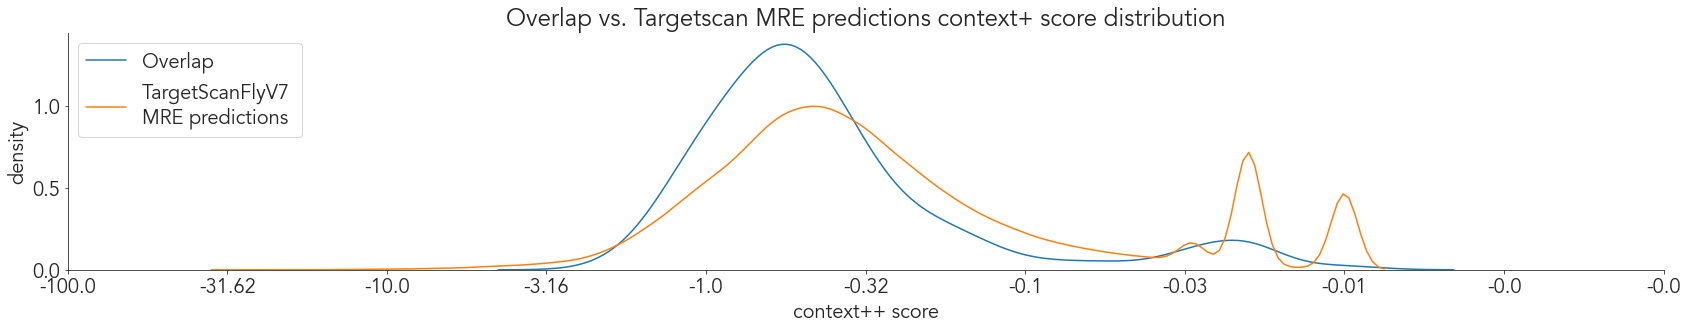

In [8]:
# Plot
## Parameters
sns.set_style("ticks")
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 12
fig_size = plt.rcParams["figure.figsize"] = [24,5]
plt.rcParams.update({'font.size': 20})

## Plot perse
sns.kdeplot(-np.log10(-overlap_results.dropna()["s_context"]), label="Overlap", shade= False, alpha = 1) # shade por si lo quieres relleno
sns.kdeplot(-np.log10(-targetscanMREs_processed.dropna()["s_context"]), label="TargetScanFlyV7 \nMRE predictions", shade= False, alpha = 1) # shade por si lo quieres relleno

## Layout
plt.title("Overlap vs. Targetscan MRE predictions context+ score distribution", fontweight = "bold")
plt.xticks(plt.xticks()[0],-np.around(np.power(10, -plt.xticks()[0]),2))
plt.xlabel("context++ score")
plt.ylabel("density")
plt.legend(loc = "upper left")
plt.tight_layout()
sns.despine()
plt.show()

In [9]:
cs_cuttoff = -0.04

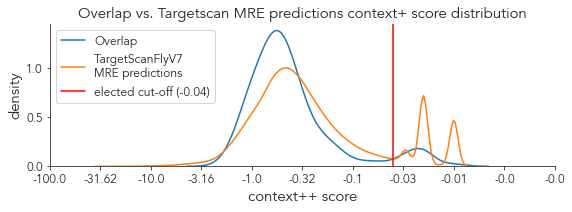

In [28]:
# Plot
## Parameters
sns.set_style("ticks")
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 12
fig_size = plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams.update({'font.size': 75})

## Plot perse
sns.kdeplot(-np.log10(-overlap_results.dropna()["s_context"]), label="Overlap", shade= False, alpha = 1) # shade por si lo quieres relleno
sns.kdeplot(-np.log10(-targetscanMREs_processed.dropna()["s_context"]), label="TargetScanFlyV7 \nMRE predictions", shade= False, alpha = 1) # shade por si lo quieres relleno
plt.axvline(-np.log10(-cs_cuttoff), c="r", label = "elected cut-off (%.2f)"%(cs_cuttoff)) 

## Layout
plt.title("Overlap vs. Targetscan MRE predictions context+ score distribution", fontweight = "bold")
plt.xticks(plt.xticks()[0],-np.around(np.power(10, -plt.xticks()[0]),2))
plt.xlabel("context++ score")
plt.ylabel("density")
plt.legend(loc = "upper left")
plt.tight_layout()
sns.despine()
plt.savefig("plots/overlap_MREpredictions.png", dpi = 500, transparent = True) # save for figure
plt.show()

## TargetScanFlyV7 MRE transcript:pairs above cut-off extraction and TargetScanFlyV7 Integrated filtering for the generation of RmiRTp

In [35]:
# Filtering loop
RmiRTp = targetscanInt_processed.copy()

for miR in RmiRTp["miRNAs"].drop_duplicates():
    entries = targetscanMREs_processed[targetscanMREs_processed["miRNA"] == miR]
    suspicius_tr = entries.loc[entries["s_context"] > cs_cuttoff,
                               "transcript_ID"].drop_duplicates()
    
    safe_tr = entries.loc[entries["s_context"] <= cs_cuttoff,
                          "transcript_ID"].drop_duplicates()
    
    drop_tr = suspicius_tr.loc[suspicius_tr.isin(safe_tr)==False]
    drop_index = RmiRTp.loc[
        ((RmiRTp["ensembl_transcript_id"].isin(drop_tr)) &
        ( RmiRTp["miRNAs"]== miR))].index
    RmiRTp.drop(index = drop_index, inplace=True)
    
RmiRTp = RmiRTp.loc[RmiRTp["Total context++ score"] < cs_cuttoff] # additional filtering step due to integrated predictions being originally clustered



# Results export
RmiRTp.to_csv("output_files/RmiRTp.tsv", sep = "\t")

RmiRTp

,external_gene_name,ensembl_transcript_id,ensembl_gene_id,Gene Symbol,miRNA family,miRNAs,Species ID,Total num conserved sites,Number of conserved 8mer sites,Number of conserved 7mer-m8 sites,Number of conserved 7mer-1a sites,Total num nonconserved sites,Number of nonconserved 8mer sites,Number of nonconserved 7mer-m8 sites,Number of nonconserved 7mer-1a sites,Total context++ score,Cumulative weighted context++ score,Aggregate PCT
0,Bx,FBtr0340366,FBgn0265598,Bx,UUGGCAC,dme-miR-263b-5p,7227,2,2,0,0,0,0,0,0,-1.418,-1.264,0.979
1,Bx,FBtr0340366,FBgn0265598,Bx,UUUGAUU,dme-miR-315-5p,7227,2,2,0,0,0,0,0,0,-2.027,-1.266,0.740
2,Bx,FBtr0340366,FBgn0265598,Bx,UAUUGUC,dme-miR-1000-5p,7227,0,0,0,0,2,0,1,1,-0.619,-0.437,0.511
3,Bx,FBtr0340366,FBgn0265598,Bx,CGGUGGG,dme-miR-278-3p,7227,1,1,0,0,0,0,0,0,-0.501,-0.373,0.392
4,Bx,FBtr0340366,FBgn0265598,Bx,UCAGCAA,dme-miR-284-3p,7227,1,1,0,0,0,0,0,0,-0.550,-0.548,0.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176384,CG11951,FBtr0473405,FBgn0039656,CG11951,UAGUUUC,dme-miR-303-3p,7227,0,0,0,0,1,0,1,0,-0.197,-0.197,NaN
176385,CG11951,FBtr0473405,FBgn0039656,CG11951,UAAAGUU,dme-miR-991-3p,7227,0,0,0,0,2,0,2,0,-0.862,-0.862,NaN
176386,CG11951,FBtr0473405,FBgn0039656,CG11951,GUUCAAC,dme-miR-4966-3p,7227,0,0,0,0,1,0,0,1,-0.050,-0.050,NaN
176387,CG11951,FBtr0473405,FBgn0039656,CG11951,CUGUUCA,dme-miR-973-3p,7227,0,0,0,0,2,0,1,1,-0.560,-0.559,NaN


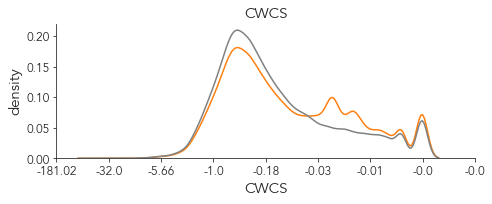

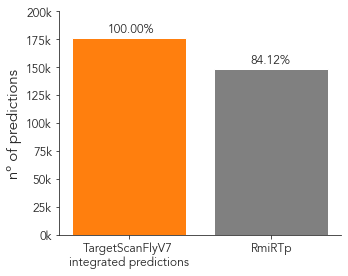

In [45]:
# Plots
## Configuration
sns.set_style("ticks")
fig = plt.figure(figsize=(7, 3))
mpl.rcParams['font.family'] = 'Avenir'
#plt.rcParams.update({'font.size': 75})

### fontsize
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



## CWCSs distplot
plt.title("CWCS")
sns.kdeplot(label = "TargetScanFlyV7 \nintegrated predictions" , color = "tab:orange", data= - np.log2(-targetscanInt_processed.loc[targetscanInt_processed["Cumulative weighted context++ score"] < 0, "Cumulative weighted context++ score"]))
sns.kdeplot(label = "RmiRTp", color = "gray",data= - np.log2(-RmiRTp.loc[RmiRTp["Cumulative weighted context++ score"] < 0, "Cumulative weighted context++ score"]))


plt.xticks(plt.xticks()[0], np.round(-2**(-plt.xticks()[0]),decimals=2))
plt.xlabel("CWCS")
plt.ylabel("density")
sns.despine()
plt.tight_layout()
plt.savefig("plots/CWCS_distro.png", dpi = 500, transparent = True)
plt.show()


## Barplot
def k_notation(n):
    return str(int(n/1000)) +"k"

fig = plt.figure(figsize=(5, 4))
bars = plt.bar([0,1],
        [targetscanInt_processed.shape[0],
         RmiRTp.shape[0]], color= ["tab:orange", "gray"])



plt.xticks([0,1],["TargetScanFlyV7 \nintegrated predictions", "RmiRTp"])
new_yticks = list(map(k_notation, plt.yticks()[0]))
plt.yticks(plt.yticks()[0],new_yticks)
plt.ylabel("nº of predictions")

for x,bar in zip([0,1],bars):
    yval = bar.get_height()
    plt.text(x-0.15, yval + 5000, "%.2f"%(100*yval/targetscanInt_processed.shape[0]) + chr(37))
    
    
sns.despine()
plt.tight_layout()
plt.savefig("plots/n_predictions.png", dpi = 500, transparent = True)
plt.show()